In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-test.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv


## Import library

In [164]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [165]:
dict_path  = '/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls'
test_path  = '/kaggle/input/GiveMeSomeCredit/cs-test.csv'
train_path = '/kaggle/input/GiveMeSomeCredit/cs-training.csv'
sample     = '/kaggle/input/GiveMeSomeCredit/sampleEntry.csv'

In [166]:
pd.set_option('display.max_colwidth', -1)
data_info = pd.read_excel(dict_path,header=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [167]:
data_info

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [168]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

## EDA

Observations:

1. [RevolvingUtilizationOfUnsecuredLines]() has 75% of the values fall under 1, but its maximum value is 50708.
2. [age]() feature has range from 0-109.
3. Both [MonthlyIncome](19.82%) and [NumberOfDepenents](2.62%) features have missing values.


### Missing values

In [169]:
train_null_sums = train_df.isnull().sum()
test_null_sums = test_df.isnull().sum()
print(f'train_null_sums: {train_null_sums}')
print(f'='*50)
print(f'test_null_sums: {test_null_sums}')

train_null_sums: Unnamed: 0                              0    
SeriousDlqin2yrs                        0    
RevolvingUtilizationOfUnsecuredLines    0    
age                                     0    
NumberOfTime30-59DaysPastDueNotWorse    0    
DebtRatio                               0    
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans         0    
NumberOfTimes90DaysLate                 0    
NumberRealEstateLoansOrLines            0    
NumberOfTime60-89DaysPastDueNotWorse    0    
NumberOfDependents                      3924 
dtype: int64
test_null_sums: Unnamed: 0                              0     
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines    0     
age                                     0     
NumberOfTime30-59DaysPastDueNotWorse    0     
DebtRatio                               0     
MonthlyIncome                           20103 
NumberOfOpenCreditLinesAndLoans         0     
NumberOfTimes90DaysLate   

In [170]:
# percentage of missing values
print(f"[MonthlyIncome] missing values percentage: {train_df['MonthlyIncome'].isnull().sum()/len(train_df)*100:.2f}%")
print(f"[NumberOfDependents] missing values percentage: {train_df['NumberOfDependents'].isnull().sum()/len(train_df)*100:.2f}%")

[MonthlyIncome] missing values percentage: 19.82%
[NumberOfDependents] missing values percentage: 2.62%


### Outlier analysis

In [171]:
# drop train_df unwanted col
train_df.drop('Unnamed: 0',axis = 1,inplace=True)

# drop test_df unwanted col
test_df.drop('Unnamed: 0',axis = 1,inplace=True)

In [172]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### RevolvingUtilizationOfUnsecuredLines

Observations:
1. most of the records are under 1 (around 98% of the population)

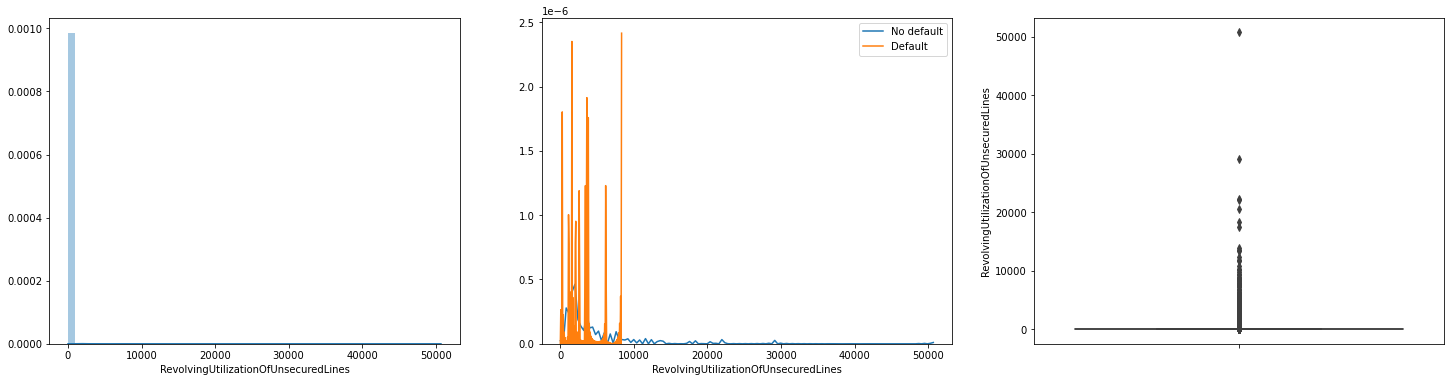

In [173]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_df['RevolvingUtilizationOfUnsecuredLines'],ax=ax1)

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0[['RevolvingUtilizationOfUnsecuredLines']], hist=False ,ax=ax2, label='No default', axlabel='RevolvingUtilizationOfUnsecuredLines')
sns.distplot(target_1[['RevolvingUtilizationOfUnsecuredLines']], hist=False ,ax=ax2, label='Default')

sns.boxplot(y='RevolvingUtilizationOfUnsecuredLines',data=train_df,ax=ax3)

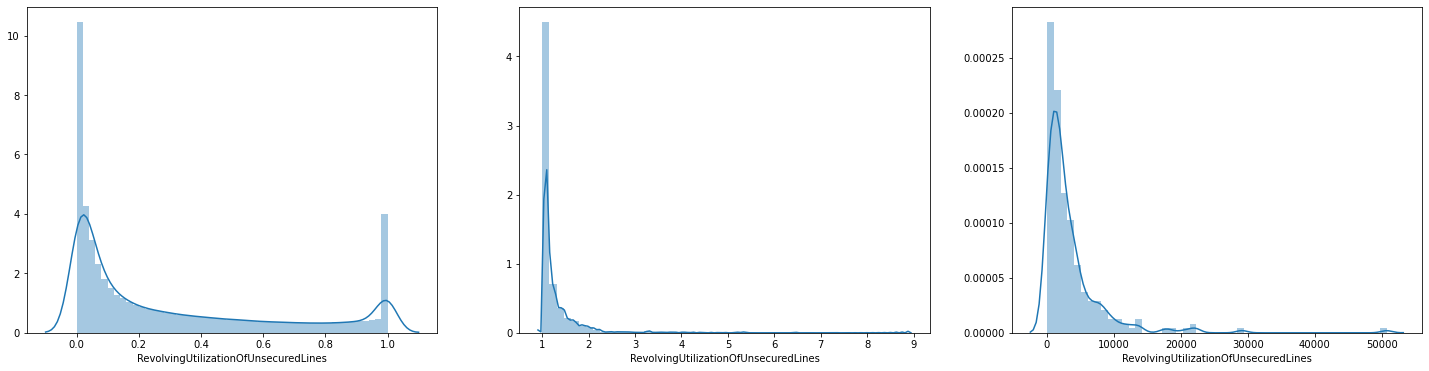

In [174]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_df.loc[train_df['RevolvingUtilizationOfUnsecuredLines']<1,'RevolvingUtilizationOfUnsecuredLines'],ax=ax1)
sns.distplot(train_df.loc[(train_df['RevolvingUtilizationOfUnsecuredLines']>=1)&(train_df['RevolvingUtilizationOfUnsecuredLines']<10),'RevolvingUtilizationOfUnsecuredLines'],ax=ax2)
sns.distplot(train_df.loc[train_df['RevolvingUtilizationOfUnsecuredLines']>=10,'RevolvingUtilizationOfUnsecuredLines'],ax=ax3)

In [175]:
rev_below_1 = sum(train_df['RevolvingUtilizationOfUnsecuredLines']<1)/len(train_df)*100
rev_1_to_10 = sum((train_df['RevolvingUtilizationOfUnsecuredLines']>=1)&(train_df['RevolvingUtilizationOfUnsecuredLines']<10))/len(train_df)*100
rev_above_10 = sum(train_df['RevolvingUtilizationOfUnsecuredLines']>=10)/len(train_df)*100

print(f'rev_below_1: {rev_below_1:.2}%')
print(f'rev_1_to_10: {rev_1_to_10:.2}%')
print(f'rev_above_10: {rev_above_10:.2}%')

rev_below_1: 9.8e+01%
rev_1_to_10: 2.1%
rev_above_10: 0.16%


In [176]:
default_count_rev = {}
for i in range(12):
    default_count_rev[i] = sum(train_df.loc[train_df['RevolvingUtilizationOfUnsecuredLines']<i,'SeriousDlqin2yrs'] == 1)/len(train_df)

In [177]:
default_count_rev

{0: 0.0,
 1: 0.05856666666666667,
 2: 0.06648,
 3: 0.06664666666666667,
 4: 0.06668666666666667,
 5: 0.06670666666666666,
 6: 0.06671333333333333,
 7: 0.06671333333333333,
 8: 0.06672,
 9: 0.06672666666666667,
 10: 0.06672666666666667,
 11: 0.06672666666666667}

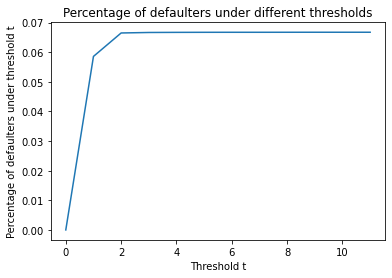

In [178]:
x, y = zip(*default_count_rev.items())
plt.plot(x, y)
plt.xlabel('Threshold t')
plt.ylabel('Percentage of defaulters under threshold t')
plt.title('Percentage of defaulters under different thresholds')
plt.show()

In [179]:
print(f"Percentage of removal: {sum(train_df['RevolvingUtilizationOfUnsecuredLines']>9)/len(train_df)*100:.2f}%")

Percentage of removal: 0.16%


### Age distribution

The distribution of the [age]() feature looks normal, but it has some outliers as shown in the boxplot.

We can use standard deviation to remove the outliers

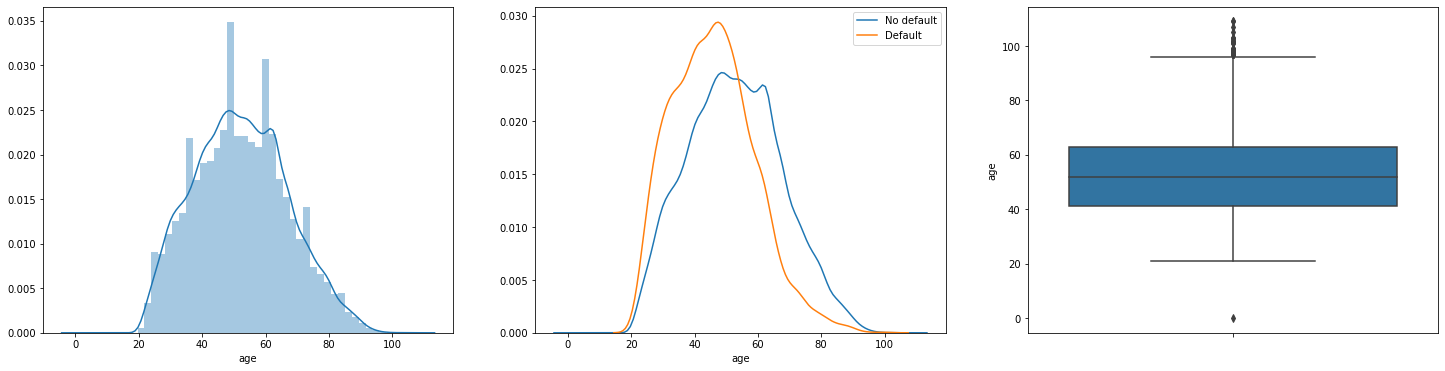

In [180]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_df['age'],ax=ax1)

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0[['age']], hist=False ,ax=ax2, label='No default', axlabel='age')
sns.distplot(target_1[['age']], hist=False ,ax=ax2, label='Default')

sns.boxplot(y='age',data=train_df,ax=ax3)

In [181]:
mean_age = train_df['age'].mean()
std_age  = train_df['age'].std()
age_upper_limit = int(mean_age + 3 * std_age)
age_lower_limit = int(mean_age - 3 * std_age)
print(f"Upper limit: {age_upper_limit}")
print(f"Lower limit: {age_lower_limit}")
print(f"Percentage of population that falls above upper limit: {sum(train_df['age']>age_upper_limit)/len(train_df)*100:.2f}%")
print(f"Percentage of population that falls below lower limit: {sum(train_df['age']<age_lower_limit)/len(train_df)*100:.2f}%")

Upper limit: 96
Lower limit: 7
Percentage of population that falls above upper limit: 0.03%
Percentage of population that falls below lower limit: 0.00%


### DebtRatio

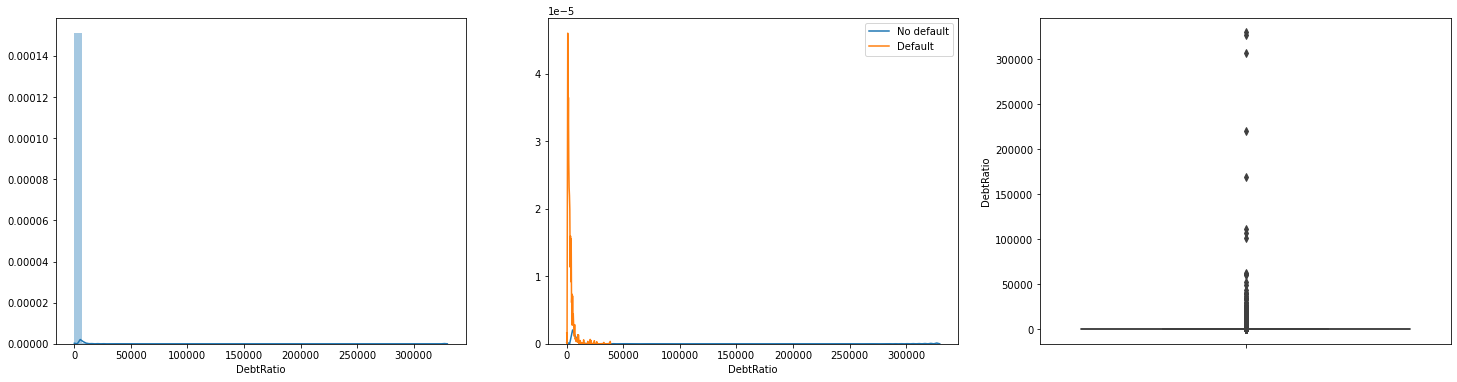

In [182]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_df['DebtRatio'],ax=ax1)

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0[['DebtRatio']], hist=False ,ax=ax2, label='No default', axlabel='DebtRatio')
sns.distplot(target_1[['DebtRatio']], hist=False ,ax=ax2, label='Default')

sns.boxplot(y='DebtRatio',data=train_df,ax=ax3)

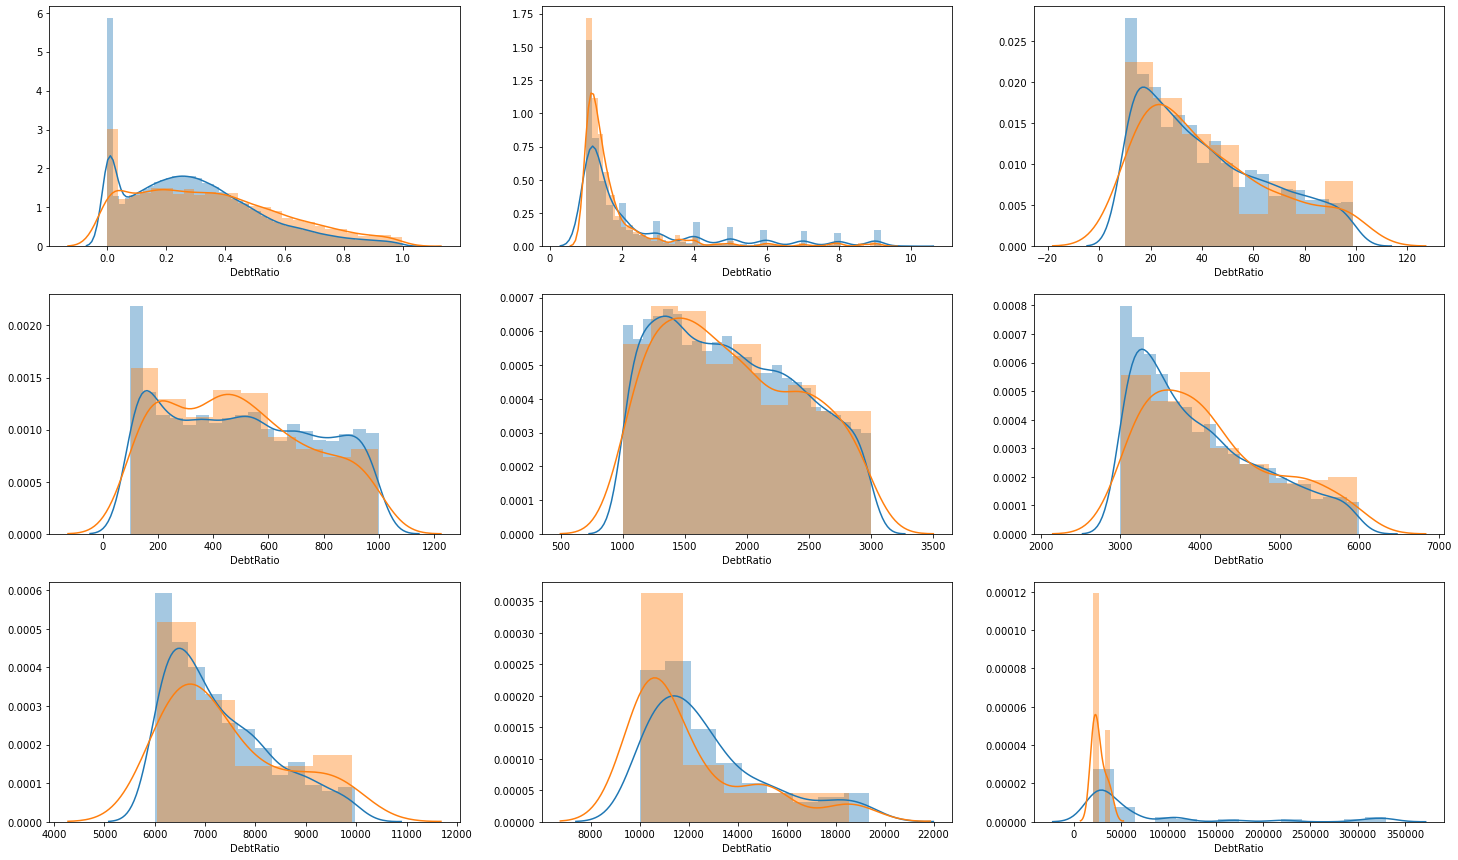

In [183]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=plt.subplots(3,3,figsize=(25,15))\

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0.loc[target_0['DebtRatio']<1,'DebtRatio'], ax=ax1, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[target_1['DebtRatio']<1,'DebtRatio'], ax=ax1, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=1)&(target_0['DebtRatio']<10),'DebtRatio'], ax=ax2, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=1)&(target_1['DebtRatio']<10),'DebtRatio'], ax=ax2, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=10)&(target_0['DebtRatio']<100),'DebtRatio'], ax=ax3, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=10)&(target_1['DebtRatio']<100),'DebtRatio'], ax=ax3, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=100)&(target_0['DebtRatio']<1000),'DebtRatio'], ax=ax4, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=100)&(target_1['DebtRatio']<1000),'DebtRatio'], ax=ax4, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=1000)&(target_0['DebtRatio']<3000),'DebtRatio'], ax=ax5, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=1000)&(target_1['DebtRatio']<3000),'DebtRatio'], ax=ax5, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=3000)&(target_0['DebtRatio']<6000),'DebtRatio'], ax=ax6, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=3000)&(target_1['DebtRatio']<6000),'DebtRatio'], ax=ax6, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=6000)&(target_0['DebtRatio']<10000),'DebtRatio'], ax=ax7, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=6000)&(target_1['DebtRatio']<10000),'DebtRatio'], ax=ax7, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=10000)&(target_0['DebtRatio']<20000),'DebtRatio'], ax=ax8, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=10000)&(target_1['DebtRatio']<20000),'DebtRatio'], ax=ax8, label='Default')

sns.distplot(target_0.loc[(target_0['DebtRatio']>=20000),'DebtRatio'], ax=ax9, label='No default', axlabel='DebtRatio')
sns.distplot(target_1.loc[(target_1['DebtRatio']>=20000),'DebtRatio'], ax=ax9, label='Default')

In [184]:
debt_count_rev = {}
for i in range(0,20000,200):
    debt_count_rev[i] = sum(train_df.loc[train_df['DebtRatio']<i,'SeriousDlqin2yrs'] == 1)/len(train_df)

In [185]:
debt_count_rev

{0: 0.0,
 200: 0.058026666666666664,
 400: 0.058986666666666666,
 600: 0.06004,
 800: 0.06072,
 1000: 0.06131333333333333,
 1200: 0.06170666666666667,
 1400: 0.06218666666666667,
 1600: 0.06262666666666666,
 1800: 0.06303333333333333,
 2000: 0.06345333333333333,
 2200: 0.06374,
 2400: 0.06399333333333333,
 2600: 0.06432666666666667,
 2800: 0.06454666666666667,
 3000: 0.06478666666666667,
 3200: 0.06493333333333333,
 3400: 0.06512666666666667,
 3600: 0.06530666666666667,
 3800: 0.06546666666666667,
 4000: 0.06563333333333334,
 4200: 0.0658,
 4400: 0.06589333333333333,
 4600: 0.06596666666666667,
 4800: 0.06605333333333334,
 5000: 0.06609333333333334,
 5200: 0.06614,
 5400: 0.06625333333333333,
 5600: 0.06628666666666666,
 5800: 0.06634666666666666,
 6000: 0.06640666666666667,
 6200: 0.06644666666666667,
 6400: 0.06646666666666666,
 6600: 0.06649333333333333,
 6800: 0.06652666666666666,
 7000: 0.06653333333333333,
 7200: 0.06658666666666667,
 7400: 0.06659333333333334,
 7600: 0.0666,
 78

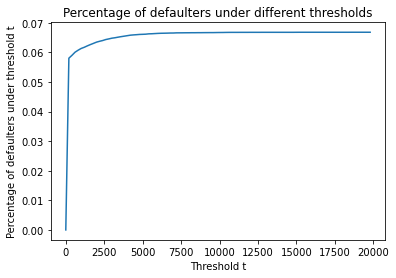

In [186]:
x, y = zip(*debt_count_rev.items())
plt.plot(x, y)
plt.xlabel('Threshold t')
plt.ylabel('Percentage of defaulters under threshold t')
plt.title('Percentage of defaulters under different thresholds')
plt.show()

In [187]:
print(f"Percentage of removal: {sum(train_df['DebtRatio']>10000)/len(train_df)*100:.2f}%")

Percentage of removal: 0.12%


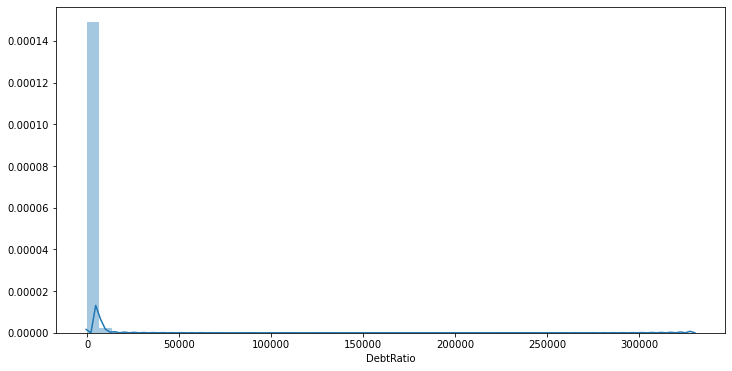

In [188]:
Debt2_after=train_df[train_df['DebtRatio']>=1]
figure=plt.figure(figsize=(12,6))
sns.distplot(Debt2_after['DebtRatio'])

### NumberOfOpenCreditLinesAndLoans

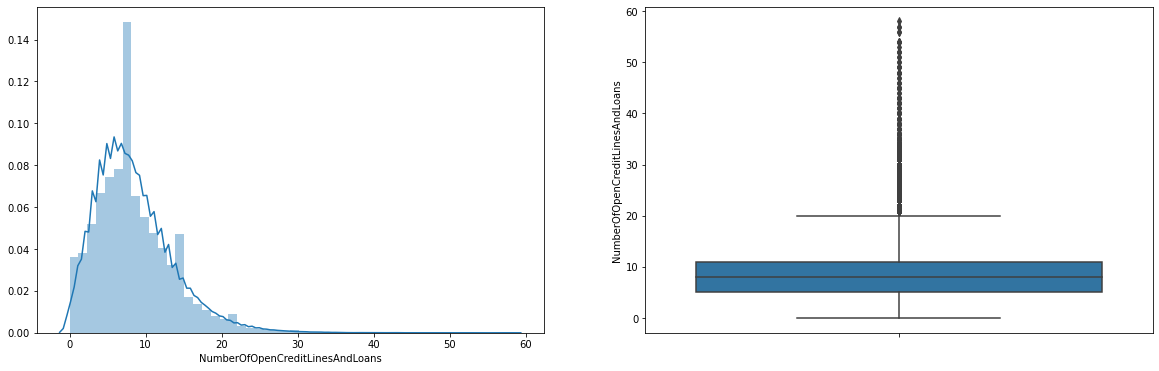

In [189]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(train_df['NumberOfOpenCreditLinesAndLoans'],ax=ax1)
sns.boxplot(y=train_df['NumberOfOpenCreditLinesAndLoans'],ax=ax2)

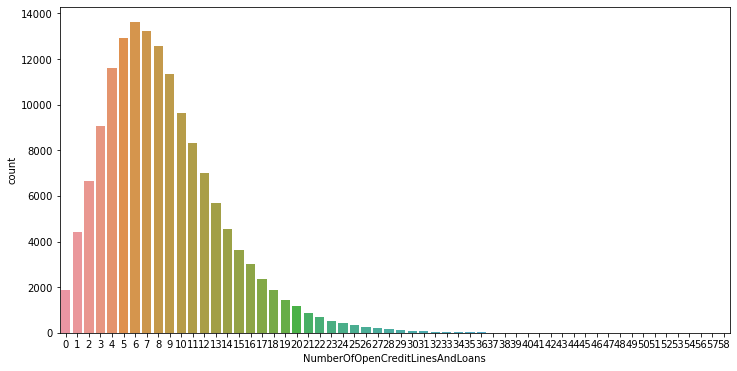

In [190]:
figure=plt.figure(figsize=(12,6))
sns.countplot(train_df['NumberOfOpenCreditLinesAndLoans'])

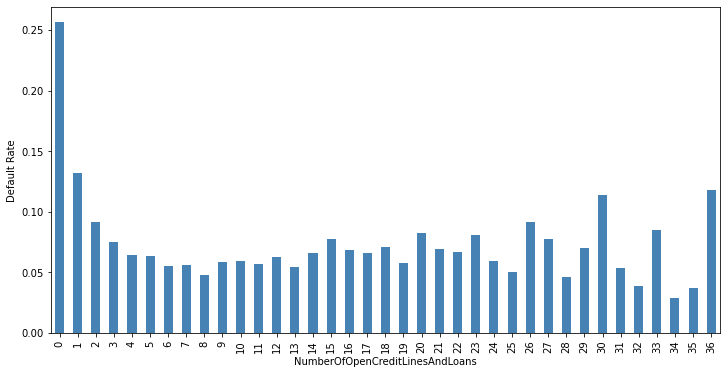

In [191]:
train_df.loc[train_df['NumberOfOpenCreditLinesAndLoans']>36,'NumberOfOpenCreditLinesAndLoans']=36
count_open = train_df.groupby(['NumberOfOpenCreditLinesAndLoans'])['SeriousDlqin2yrs'].sum()
total_open = train_df.groupby(['NumberOfOpenCreditLinesAndLoans'])['SeriousDlqin2yrs'].count()
ratio_open = count_open/total_open
ratio_open.plot(kind='bar',figsize=(12,6),color='#4682B4', ylabel='Default Rate')

In [192]:
sum(train_df['NumberOfOpenCreditLinesAndLoans']>36)/len(train_df)

0.0

### NumberRealEstateLoansOrLines

Some observations:
- it is surprising to learn that the default rate is not at the lowest when the number of real estate loan is 0.

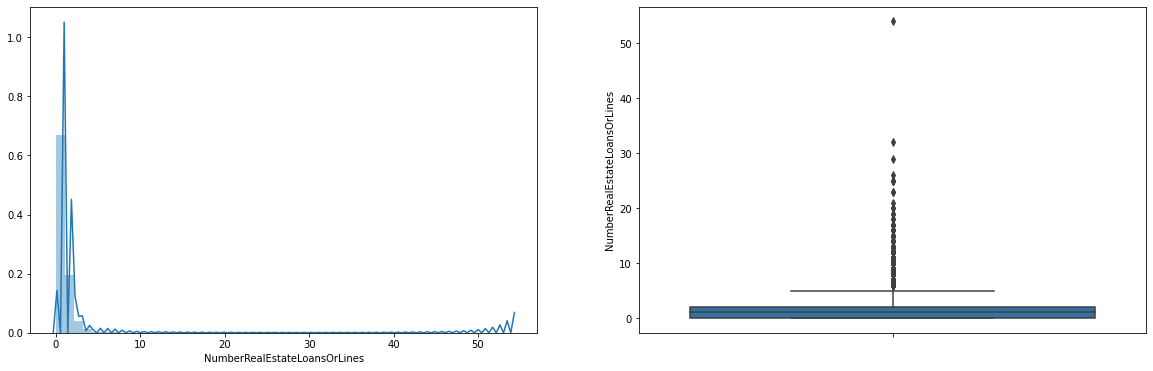

In [193]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(train_df['NumberRealEstateLoansOrLines'],ax=ax1)
sns.boxplot(y=train_df['NumberRealEstateLoansOrLines'],ax=ax2)

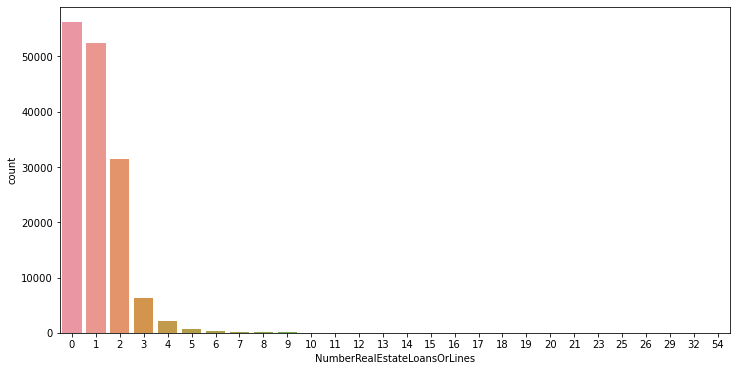

In [194]:
figure=plt.figure(figsize=(12,6))
sns.countplot(train_df['NumberRealEstateLoansOrLines'])

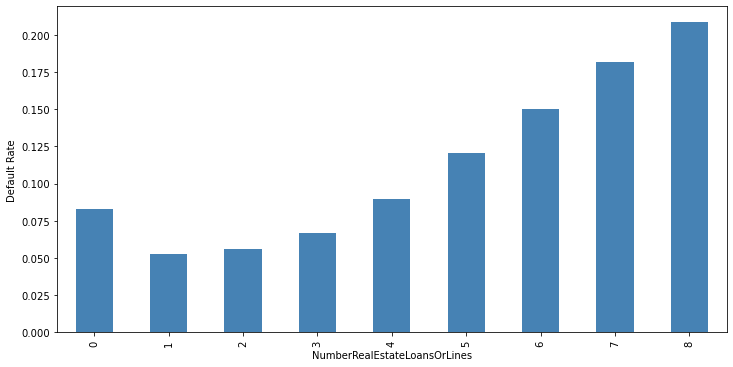

In [195]:
train_df.loc[train_df['NumberRealEstateLoansOrLines']>8,'NumberRealEstateLoansOrLines']=8
count_open = train_df.groupby(['NumberRealEstateLoansOrLines'])['SeriousDlqin2yrs'].sum()
total_open = train_df.groupby(['NumberRealEstateLoansOrLines'])['SeriousDlqin2yrs'].count()
ratio_open = count_open/total_open
ratio_open.plot(kind='bar',figsize=(12,6),color='#4682B4',ylabel='Default Rate')

### NumberOfDependents

Some observations:
- it is interesting to see that when the [NumberOfDependents]() are missing, the record for the [MonthlyIncome]() is also missing
- majority of the [NumberOfDependents]() with no missing value is 0

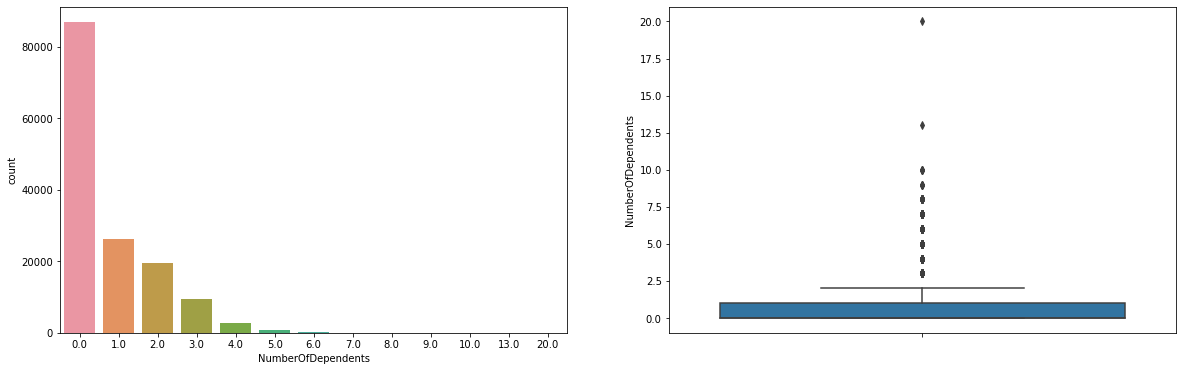

In [196]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(train_df['NumberOfDependents'],ax=ax1)
sns.boxplot(y=train_df['NumberOfDependents'],ax=ax2)

In [197]:
train_df['NumberOfDependents'].isnull().sum()

3924

In [198]:
train_df['MonthlyIncome'].isnull().sum()

29731

In [199]:
train_df.loc[(train_df['NumberOfDependents'].isnull())&(train_df['MonthlyIncome'].isnull()),:].shape[0]

3924

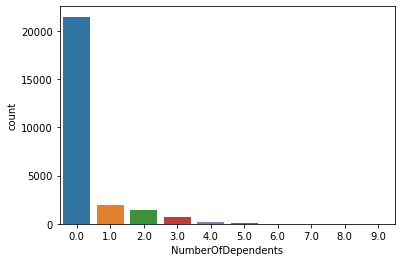

In [200]:
sns.countplot(train_df.loc[(train_df['NumberOfDependents'].notnull())&(train_df['MonthlyIncome'].isnull()),:]['NumberOfDependents'])

### Number of borrower due (30-59,60-89,90)

It seems like 80 is a good threshold to filter out the outliers

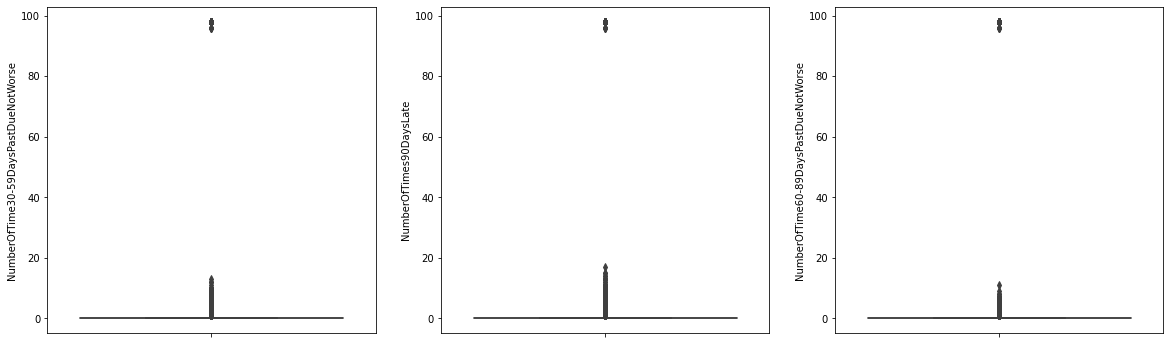

In [201]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(20,6))
sns.boxplot(y=train_df['NumberOfTime30-59DaysPastDueNotWorse'],ax=ax1)
sns.boxplot(y=train_df['NumberOfTime60-89DaysPastDueNotWorse'],ax=ax3)
sns.boxplot(y=train_df['NumberOfTimes90DaysLate'],ax=ax2)

In [202]:
past30 = train_df['NumberOfTime30-59DaysPastDueNotWorse']>80
past60 = train_df['NumberOfTime60-89DaysPastDueNotWorse']>80
past90 = train_df['NumberOfTimes90DaysLate']>80

print(f'past30: {sum(past30)}')
print(f'past60: {sum(past60)}')
print(f'past90: {sum(past90)}')

print(f'past30 & past60 & past90: {len(train_df.loc[(past30)&(past60)&(past90),:])}')

past30: 269
past60: 269
past90: 269
past30 & past60 & past90: 269


### Monthly Income

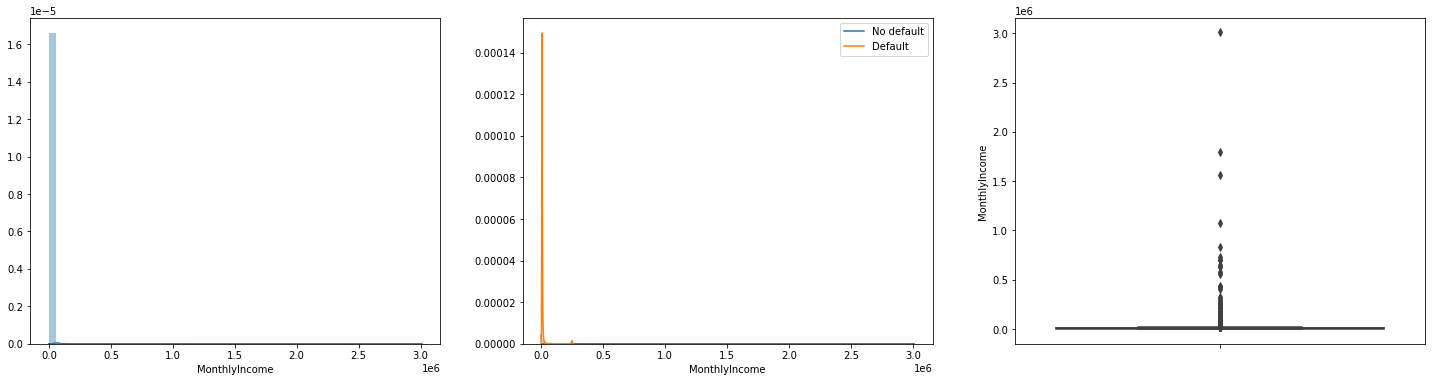

In [203]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(25,6))
sns.distplot(train_df['MonthlyIncome'],ax=ax1)

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0[['MonthlyIncome']], hist=False ,ax=ax2, label='No default', axlabel='MonthlyIncome')
sns.distplot(target_1[['MonthlyIncome']], hist=False ,ax=ax2, label='Default')

sns.boxplot(y='MonthlyIncome',data=train_df,ax=ax3)

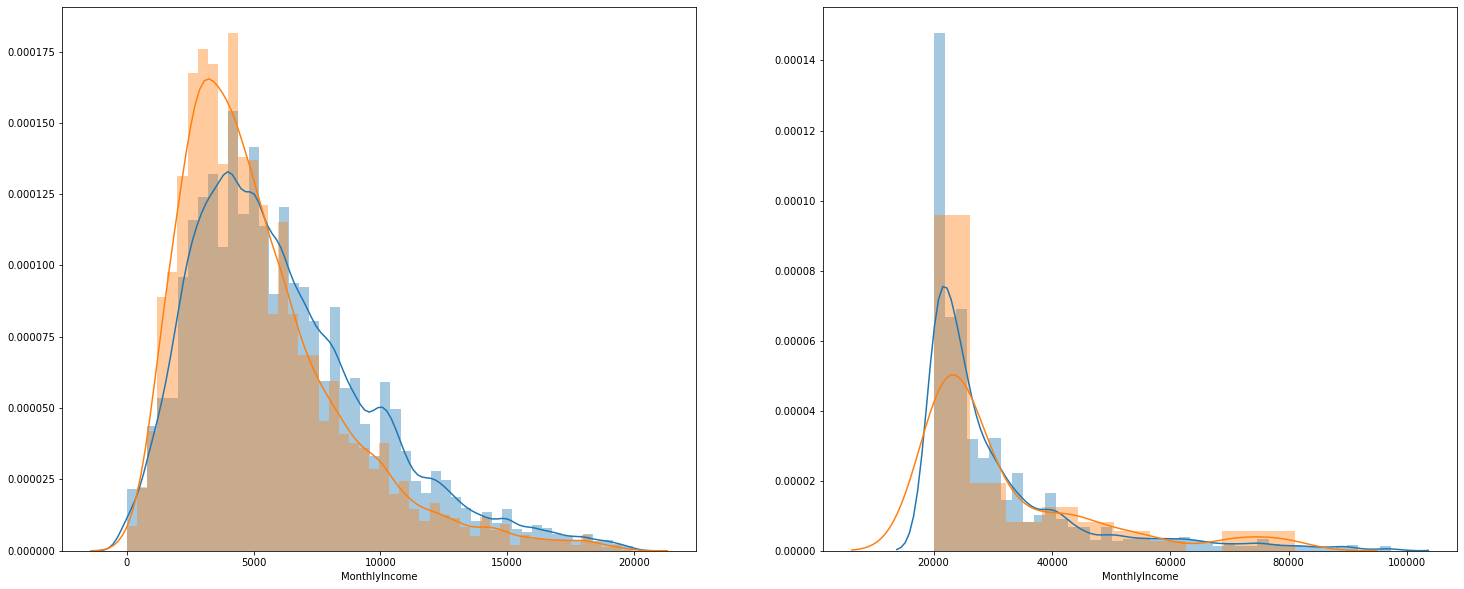

In [204]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(25,10))

target_0 = train_df.loc[train_df['SeriousDlqin2yrs'] == 0]
target_1 = train_df.loc[train_df['SeriousDlqin2yrs'] == 1]

sns.distplot(target_0.loc[(target_0['MonthlyIncome']>=1)&(target_0['MonthlyIncome']<20000),'MonthlyIncome'], ax=ax1, label='No default', axlabel='MonthlyIncome')
sns.distplot(target_1.loc[(target_1['MonthlyIncome']>=1)&(target_1['MonthlyIncome']<20000),'MonthlyIncome'], ax=ax1, label='Default')

sns.distplot(target_0.loc[(target_0['MonthlyIncome']>=20000)&(target_0['MonthlyIncome']<100000),'MonthlyIncome'], ax=ax2, label='No default', axlabel='MonthlyIncome')
sns.distplot(target_1.loc[(target_1['MonthlyIncome']>=20000)&(target_1['MonthlyIncome']<100000),'MonthlyIncome'], ax=ax2, label='Default')

### Pearson correlation matrix

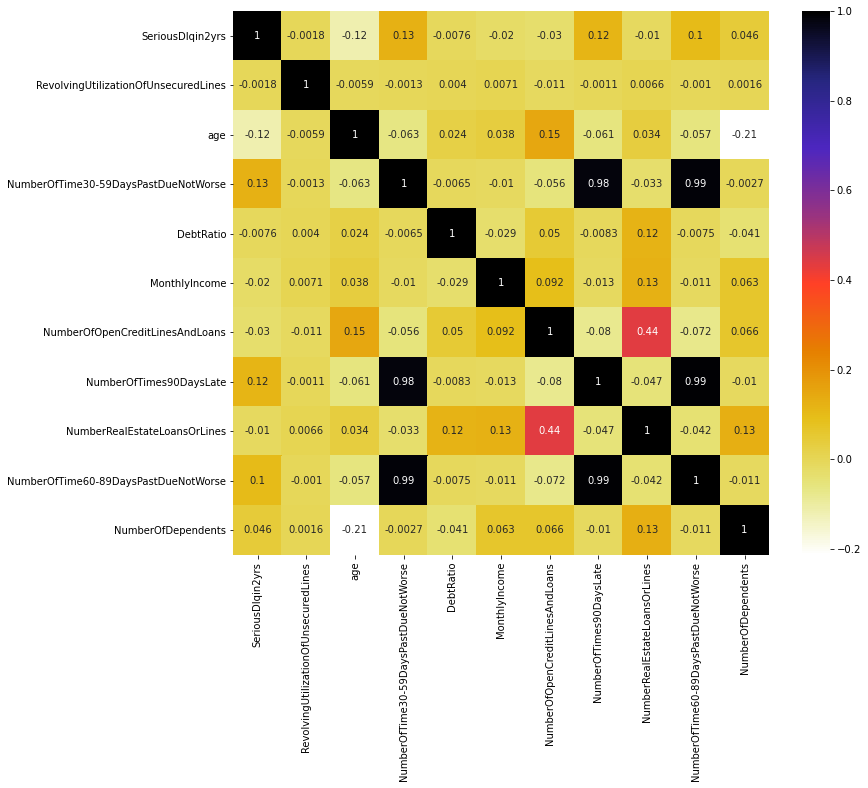

In [205]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

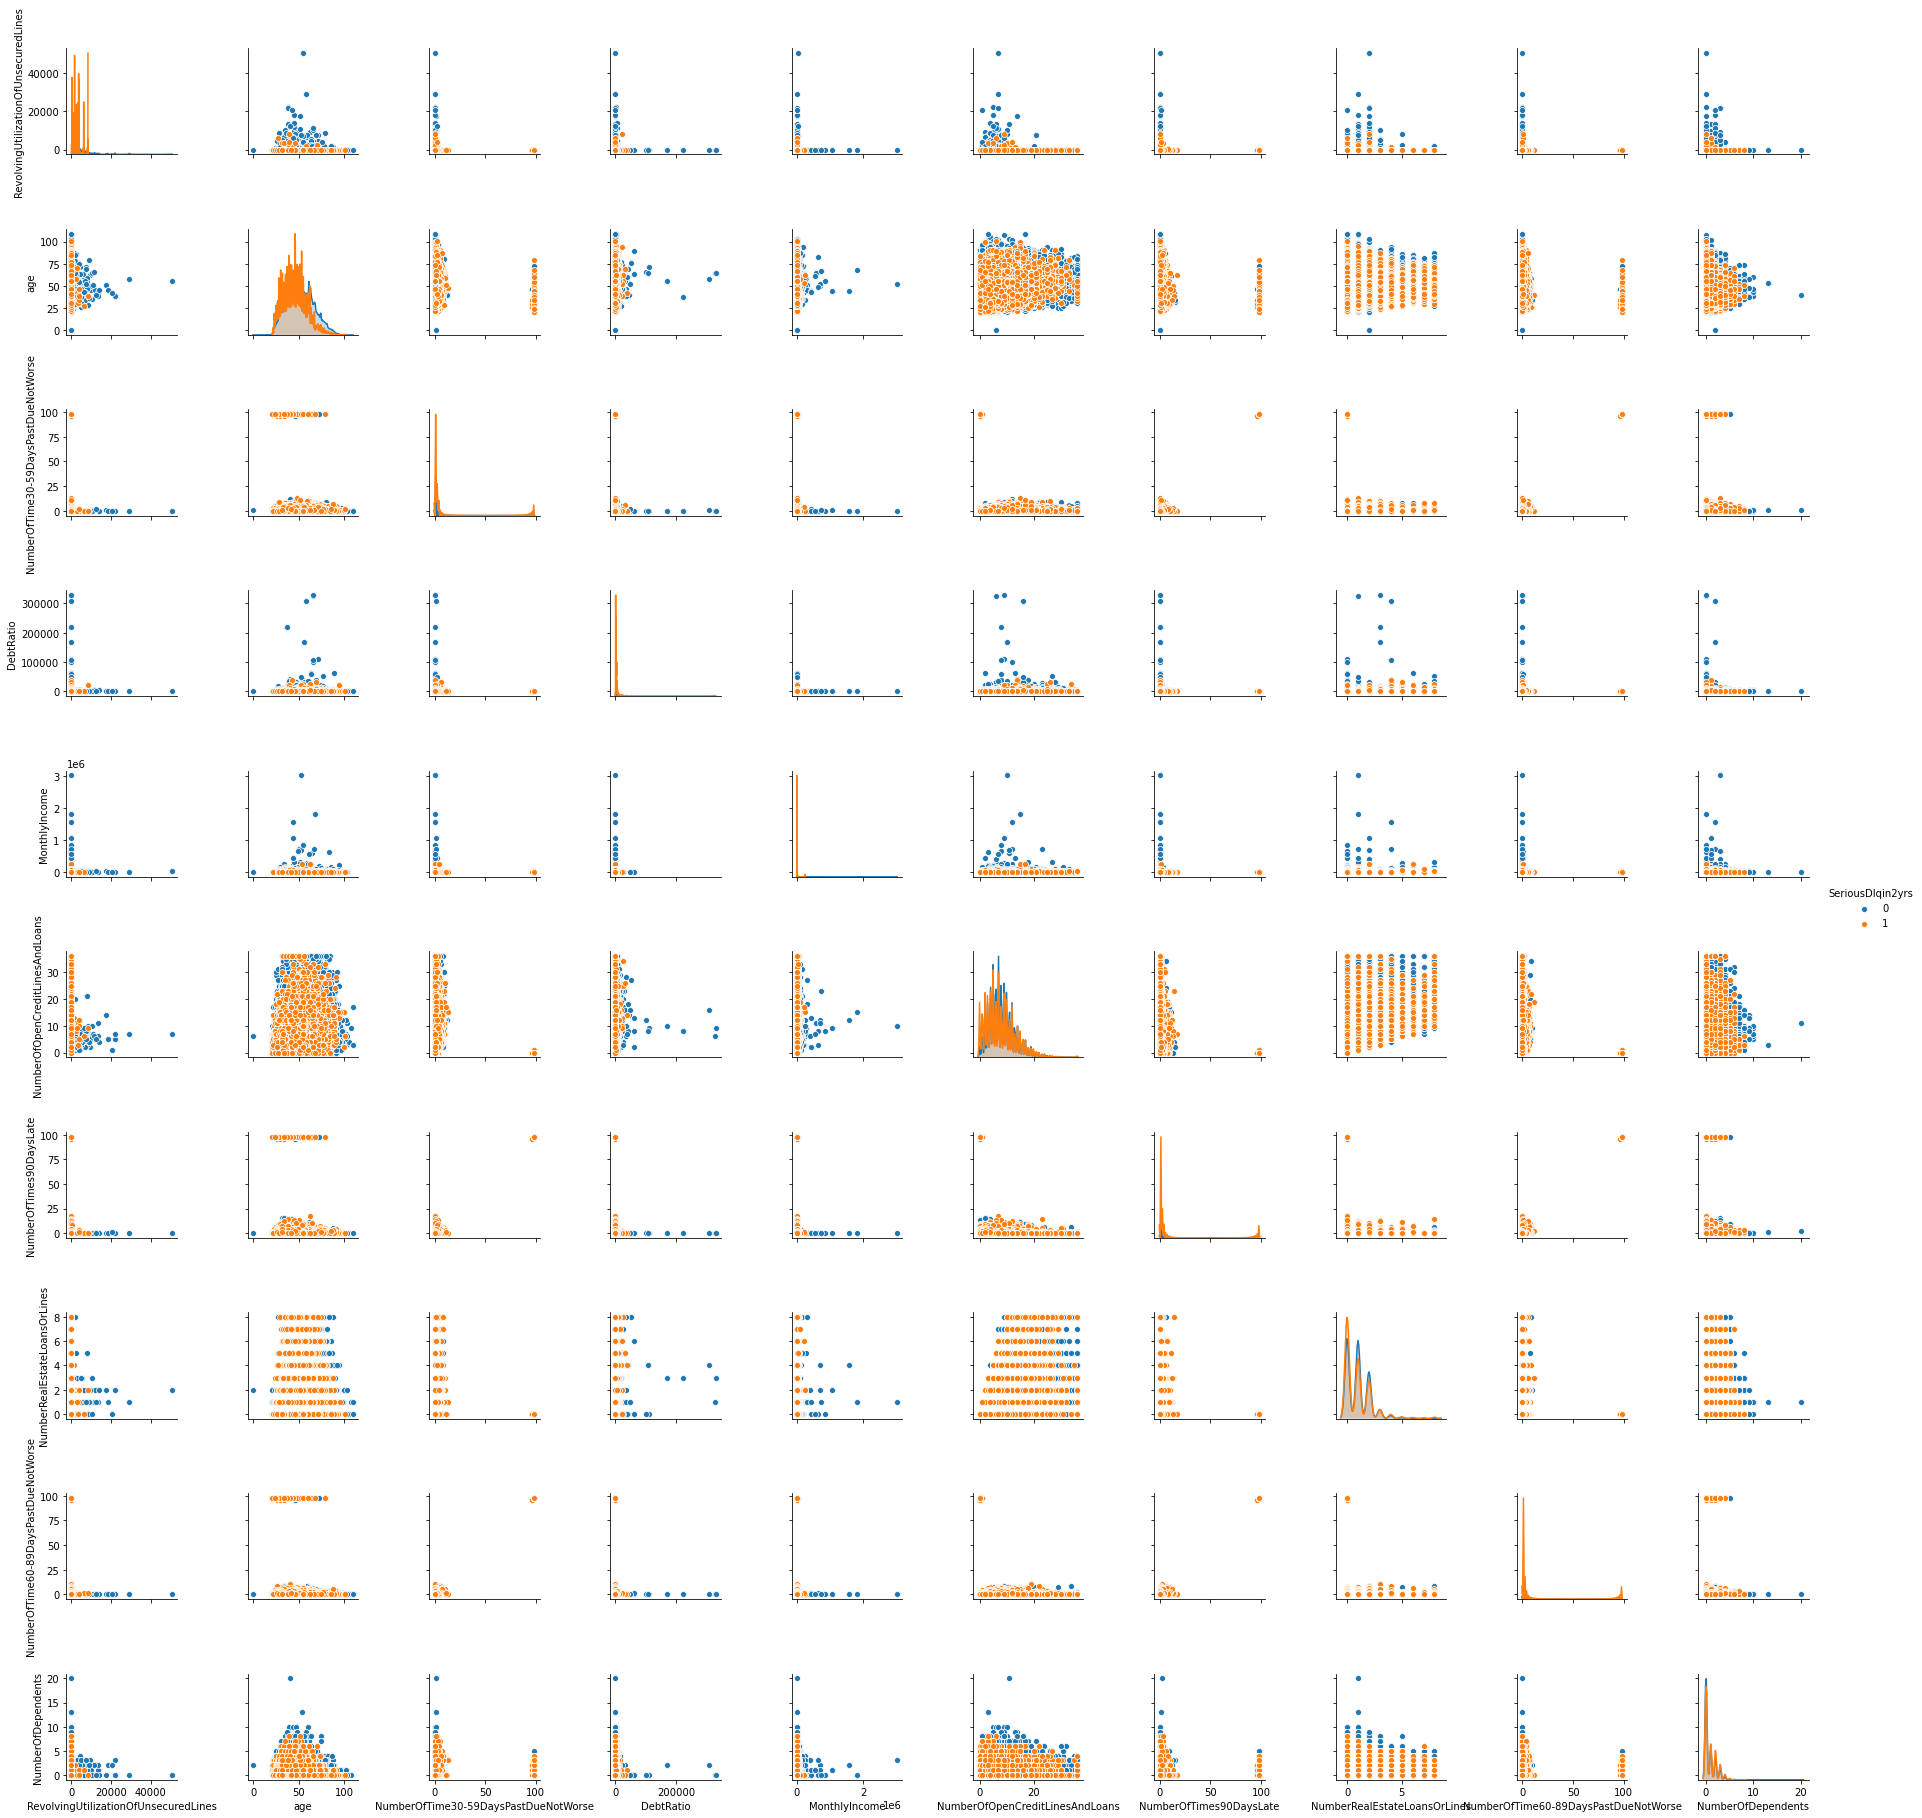

In [206]:
sns.pairplot(train_df, hue="SeriousDlqin2yrs", diag_kws={'bw': 0.2})

### Baseline -> random guess result

There are more good records (93.32%) than bad records (6.68%)

Percentage of default: 6.68%
Percentage of non-default: 93.32%


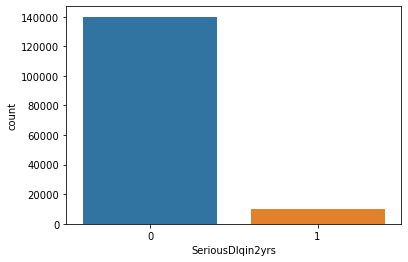

In [207]:
print(f"Percentage of default: {sum(train_df['SeriousDlqin2yrs'] == 1)/len(train_df)*100:.2f}%")
print(f"Percentage of non-default: {sum(train_df['SeriousDlqin2yrs'] == 0)/len(train_df)*100:.2f}%")
sns.countplot('SeriousDlqin2yrs', data=train_df)

## Data Preprocessing

In [208]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [209]:
def transformation(df,
                   split,
                   age_lower_limit=None, age_upper_limit=None,
                   debt_threshold=None,
                   revol_threshold=20,
                   numlate_threshold=80,
                   numreal_threshold=8,
                   numopen_threshold=36,
                   numdepend_miss=0,
                   monthincome_miss='mean'
                   ):
    
    df.drop('Unnamed: 0',axis = 1,inplace=True)
    
    assert split in ['train','test'], 'split must be train or test'
    
    if split=='train':
        # Filter age
        df = df[df['age']>age_lower_limit]
        df = df[df['age']<age_upper_limit]

        # Filter RevolvingUtilizationOfUnsecuredLines
        df = df[df['RevolvingUtilizationOfUnsecuredLines']<revol_threshold]

        # Filter NumberOfTimes##DaysLate
        df = df[df['NumberOfTime30-59DaysPastDueNotWorse']<=numlate_threshold]
        df = df[df['NumberOfTime60-89DaysPastDueNotWorse']<=numlate_threshold]
        df = df[df['NumberOfTimes90DaysLate']<=numlate_threshold]

        # Filter DebtRatio
        df = df[df['DebtRatio']<=debt_threshold]
    
        # Regroup NumberRealEstateLoansOrLines
        df.loc[df['NumberRealEstateLoansOrLines']>numreal_threshold,'NumberRealEstateLoansOrLines']=numreal_threshold

        # Regroup NumberOfOpenCreditLinesAndLoans
        df.loc[df['NumberOfOpenCreditLinesAndLoans']>numopen_threshold,'NumberOfOpenCreditLinesAndLoans']=numopen_threshold

    # Handling missing values
    # Fill NumberOfDependents missing values with 0
    df.loc[df['NumberOfDependents'].isnull(),'NumberOfDependents'] = numdepend_miss
    
    assert monthincome_miss in ['mean','median'], 'Monthly income must be filled with median or mean'
    
    # Fill MonthlyIncome missing values
    if monthincome_miss == 'mean':
        df.loc[df['MonthlyIncome'].isnull(),'MonthlyIncome'] = df['MonthlyIncome'].mean()
    else:
        df.loc[df['MonthlyIncome'].isnull(),'MonthlyIncome'] = df['MonthlyIncome'].median()
    
    return df

In [210]:
train_df = transformation(train_df, split='train',
                          revol_threshold=9,
                          age_lower_limit=age_lower_limit,
                          age_upper_limit=age_upper_limit,
                          debt_threshold=10000)
test_df  = transformation(test_df, split='test')

double check the missing values

In [211]:
train_null_sums = train_df.isnull().sum()
test_null_sums = test_df.isnull().sum()
print(f'train_null_sums: {train_null_sums}')
print(f'='*50)
print(f'test_null_sums: {test_null_sums}')

train_null_sums: SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64
test_null_sums: SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines    0     
age                                     0     
NumberOfTime30-59DaysPastDueNotWorse    0     
DebtRatio                               0     
MonthlyIncome                           0     
NumberOfOpenCreditLinesAndLoans         0     
NumberOfTimes90DaysLate                 0     
NumberRealEstateLoansOrLines            0     
NumberOfTime60-89DaysPastDueNotWorse    0     
NumberOfDependents    

In [212]:
train_x = train_df.iloc[:,1:]
train_y = train_df['SeriousDlqin2yrs']
test_x = test_df.iloc[:,1:]

## XGB Classifier

This is the main classifier. I was able to achieve 0.86822 for the private score.

In [213]:
import xgboost as xgb
from sklearn import model_selection

In [298]:
params = {'subsample': 0.7,
          'n_estimators':1000,
          'min_child_weight': 9.0,
          'objective': 'binary:logistic',
          'gamma': 0.65,
          'max_depth': 6,
          'max_delta_step': 1.8,
          'colsample_bytree': 0.5,
          'eta': 0.01,
          'tree_method':'gpu_hist'}
xg_cls = xgb.XGBClassifier(**params)
cross_val_score(xg_cls, train_x, train_y, scoring='roc_auc')

array([0.86361874, 0.86273762, 0.8642851 , 0.86441647, 0.87061285])

In [299]:
# training
xg_cls.fit(train_x, train_y)

# inference
preds_xgb_classifier = xg_cls.predict_proba(test_x)
preds_xgb_classifier = np.clip(preds_xgb_classifier, a_min = 0., a_max = 1.)

# submission
sampleEntry = pd.read_csv(sample)
sampleEntry['Probability'] = preds_xgb_classifier[:,1]
export_csv = sampleEntry.to_csv('export_dataframe.csv',index = None,header=True)

### Feature importance

In [300]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xg_cls)

In [ ]:
shap_values = explainer.shap_values(test_x)

In [ ]:
shap.summary_plot(shap_values, test_x, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, test_x)

## [Optional] Extra experiments for other classifiers

The classifiers below does not contribute better accuracy than the xgb_classifier. Hence, I only run experiments to test their output accuracy. For the submission, I used the result from the xgb_classifier.

## XGB Regressor

In [ ]:
params = {'subsample': 0.7,
          'n_estimators':1000,
          'min_child_weight': 9.0,
          'objective': 'binary:logistic',
          'gamma': 0.65,
          'max_depth': 6,
          'max_delta_step': 1.8,
          'colsample_bytree': 0.5,
          'eta': 0.01,
          'tree_method':'gpu_hist'}
xg_reg = xgb.XGBRegressor(**params)
cross_val_score(xg_reg, train_x, train_y, scoring='roc_auc')

In [ ]:
# training
xg_reg.fit(train_x,train_y)

# inference
preds_xgb_regressor = xg_reg.predict(test_x)
preds_xgb_regressor = np.clip(preds_xgb_regressor, a_min = 0., a_max = 1.)

## MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_x_ = scaler.fit_transform(train_x)
train_x_ = pd.DataFrame(train_x_, index=train_x.index, columns=train_x.columns)

test_x_ = scaler.fit_transform(test_x)
test_x_ = pd.DataFrame(test_x_, index=test_x.index, columns=test_x.columns)

In [ ]:
mlpreg = MLPRegressor(random_state=1,
                      max_iter=100,
                      hidden_layer_sizes=(100,)).fit(train_x_, train_y)
cross_val_score(mlpreg, train_x_, train_y, scoring='roc_auc')

In [ ]:
preds_mlpregr = mlpreg.predict(test_x_)
preds_mlpregr = np.clip(preds_mlpregr, a_min = 0., a_max = 1.)

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlpcls = MLPClassifier(random_state=1,
                       max_iter=400,
                       hidden_layer_sizes=(100,),
                       learning_rate='adaptive').fit(train_x_, train_y)
cross_val_score(mlpcls, train_x_, train_y, scoring='roc_auc')

In [ ]:
preds_mlpcls = mlpcls.predict_proba(test_x_)
preds_mlpcls = preds_mlpcls[:,1]
preds_mlpcls = np.clip(preds_mlpcls, a_min = 0., a_max = 1.)

## Keras Deep Learning Model

In [ ]:
import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import LeakyReLU, PReLU, ELU, Dense, Dropout, Input

In [ ]:
# model initializer
initializer = tf.keras.initializers.HeUniform()

# build model
deep_classifier = Sequential()
deep_classifier.add(Input(shape=(10,)))
deep_classifier.add(Dense(100,kernel_initializer=initializer,activation='relu',name="layer1"))
deep_classifier.add(Dense(1,kernel_initializer=initializer,activation='sigmoid',name="classifier"))

deep_classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        optimizer='Adam')

# start training
model_history = deep_classifier.fit(train_x_.values,
                                    train_y.values,
                                    validation_split=0.1,
                                    batch_size=10,
                                    epochs=10,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [ ]:
train_preds_deep_model = deep_classifier.predict(train_x_.values)
roc_auc_score(train_y.values,train_preds_deep_model)

In [ ]:
preds_deep_model = deep_classifier.predict(test_x_.values)

## Combining and outputing result for all

You can average the predictions result from various classifiers to boost your final accuracy

In [ ]:
preds = (preds_xgb_classifier + preds_xgb_regressor + preds_mlpregr)/3

In [137]:
sampleEntry = pd.read_csv(sample)
sampleEntry['Probability'] = preds
export_csv = sampleEntry.to_csv('export_dataframe.csv',index = None,header=True)